# Create multliayer Food groups 

In [1]:
import pandas as pd
import numpy as np
import time
import networkx as nx
import geopandas as gpd # pip installed
import matplotlib.pyplot as plt 

In [50]:
def Edge_overlap_w(data,weight):
    """Calculate the weighted edge overlap for each 'origin_country_ISO' in a DataFrame.

    In weighted multilayer networks the edge overlap is the sum of all the weights of all out-links in each node.  

    Parameters:
    - data (pd.DataFrame): Input DataFrame containing at least the 'origin_country_ISO' and 'value' columns.

    Returns:
    pd.DataFrame: DataFrame with edge overlap calculated for each 'origin_country_ISO'.
    The output DataFrame has one column named 'overlap' representing the calculated edge overlap weights.

    Example:
    >>> df_result = Edge_overlap_w(input_data)
    """
    if weight==True:
        overlap_w= data.groupby(['origin_country_ISO']).apply(lambda group : group.value.sum())
    else:
        overlap_w= data.groupby(['origin_country_ISO']).apply(lambda group : len(group))

    overlap_w= pd.DataFrame(overlap_w.sort_values(ascending=False),columns=['o_i'])
    return overlap_w

def Node_strength_w(data):
    """ Calculate the node relevance in each layer of the multilayer network. 
    In a weighted directed network the country strenght is the sum of the magnitude exported by that country in that layer.

    Parameters:
    - data (pd.DataFrame): Input DataFrame containing trade data for a single year. The dataframe must contain 
    the columns: 'item', 'unit', 'origin_country_ISO', and 'value'.

    Returns:
    pd.DataFrame: DataFrame with country strength for each combination of 'item' and 'unit', sorted from highest to lowest. 
    Columns include 'Food_group', 'unit', 'origin_country_ISO', and the calculated 'value' for node strength.

    Example:
    >>> df_result = Node_strength_w(input_data)
    """

    str_i_l = data.groupby(['Food_group','unit']).apply(lambda group: group.loc[:,['origin_country_ISO','value']].
                                                        pivot_table(index='origin_country_ISO', aggfunc='sum').
                                                        sort_values(by = 'value',ascending=False))
    # Reset multi-index:
    strength_i_l= str_i_l.reset_index(level=['Food_group','unit','origin_country_ISO']).rename(columns={'value':'str_i_l'})

    return strength_i_l
    
def Node_strength(data, weight = True):
    """ Calculate the node relevance in each layer of the multilayer network. 
    In a weighted directed network the country strenght is the sum of the magnitude exported by that country in that layer.

    Parameters:
    - data (pd.DataFrame): Input DataFrame containing trade data for a single year. The dataframe must contain 
    the columns: 'item', 'unit', 'origin_country_ISO', and 'value'.

    Returns:
    pd.DataFrame: DataFrame with country strength for each combination of 'item' and 'unit', sorted from highest to lowest. 
    Columns include 'item', 'unit', 'origin_country_ISO', and the calculated 'value' for node strength.

    Example:
    >>> df_result = Node_strength_w(input_data)
    """
    
    if (weight==True):
        str_i_l = data.groupby(['item','unit']).apply(lambda group: group.loc[:,['origin_country_ISO','value']].
                                                        pivot_table(index='origin_country_ISO', aggfunc='sum').
                                                        sort_values(by = 'value',ascending=False))
        strength_i_l= str_i_l.reset_index(level=['item','unit','origin_country_ISO']).rename(columns={'value':'str_i_l'})

    else:
        str_i_l = data.groupby(['item','unit']).apply(lambda group: group.loc[:,['origin_country_ISO','value']].
                                                        pivot_table(index='origin_country_ISO', aggfunc=lambda x: len(x.unique())).
                                                        sort_values(by = 'value',ascending=False))
        strength_i_l= str_i_l.reset_index(level=['item','unit','origin_country_ISO']).rename(columns={'value':'str_i_l'})

    return strength_i_l
    
def Participation_coeff_old (data,overlap):

    #Define elements for part_coeff
    L = len(data.Food_group.unique())

    
    s_i_l = Node_strength_w(data)

    # Prepare data
    data_for_Pc = pd.merge(s_i_l, overlap.loc[:,['country','overl']], left_on= 'origin_country_ISO',right_on='country', how='left')


    # Contibution of each layer to total exports
    data_for_Pc['sum_layers'] = (data_for_Pc['str_i_l']/data_for_Pc['overl'])**2
    
    sum_layers= data_for_Pc.groupby(['origin_country_ISO']).apply(lambda group: group.sum_layers.sum())

    particip_coeff =  pd.DataFrame((L/(L-1))*(1- sum_layers),columns=['partic_coeff']).sort_values(by='partic_coeff',ascending=False)
    return particip_coeff 
  
def Participation_coeff (data, overlap, direction, weight=True):

    if (weight == True):
        w_f = '_w'
        flag_overlap = 'overl'
    else:
        w_f = ''
        flag_overlap = 'deg'

    #Define elements for part_coeff
    L = len(data.item.unique())
    
    s_i_l = Node_strength(data,weight)

    # Prepare data
    #data_for_Pc = pd.merge(s_i_l, o_i, left_on= 'origin_country_ISO',right_index=True, how='left')
    data_for_Pc = pd.merge(s_i_l, overlap.loc[:,['country',direction+'_'+flag_overlap]], left_on= 'origin_country_ISO',right_on='country', how='left')

    # Contibution of each layer to total exports:
    data_for_Pc['sum_layers'] = (data_for_Pc['str_i_l']/data_for_Pc[direction+'_'+flag_overlap])**2
    
    sum_layers= data_for_Pc.groupby(['origin_country_ISO']).apply(lambda group: group.sum_layers.sum())

    particip_coeff = (pd.DataFrame((L/(L-1))*(1- sum_layers),columns=['pc'+w_f+'_'+direction]).
                      sort_values(by='pc'+w_f+'_'+direction,ascending=False))
    return particip_coeff 


def Agregated_network (edge_data,node_info, group_class):

    # General network 
    pos_dict = node_info.loc[:,['ISO','pos','name']].set_index('ISO').to_dict(orient='index')
    pos_dict

    edge_dict =dict(zip(zip(edge_data['origin_country_ISO'], edge_data['destin_country_ISO'], edge_data[group_class]), data['value']))
    edge_dict

    # Create network
    G=nx.MultiDiGraph()

    G.add_nodes_from(pos_dict)
    nx.set_node_attributes(G,pos_dict)

    G.add_edges_from(edge_dict.keys())
    nx.set_edge_attributes(G, edge_dict, 'weight')
    nx.set_edge_attributes(G, edge_dict.keys(), '<attribute_name>')
    return G
        

In [96]:
year_check=2019#'2019-2021'
direction = 'out'
group_class = 'Food_group'
#data = pd.read_pickle('../Data/Data_year_groups_12.pkl')
data = pd.read_pickle('../Data/Data_food_groups.pkl')

data = data.loc[(data.unit =='1000 US$') & (data.year == year_check) & (data.value > 0) ,:]

country_metadata = pd.read_pickle('../Data/Country_info.pkl')

In [97]:
data

,index,destin_country_ISO,origin_country_ISO,year,unit,value,origin_country,destin_country,L1_foodex,Food_group
14,14,KW,SI,2019,1000 US$,76.0,Slovenia,Kuwait,A01BS,Fruit and fruit products
41,49,KW,NZ,2019,1000 US$,1897.0,New Zealand,Kuwait,A01BS,Fruit and fruit products
105,365,KW,GH,2019,1000 US$,154.0,Ghana,Kuwait,A01BS,Fruit and fruit products
151,473,KW,EG,2019,1000 US$,30561.0,Egypt,Kuwait,A01BS,Fruit and fruit products
199,2003,KW,MX,2019,1000 US$,3861.0,Mexico,Kuwait,A01BS,Fruit and fruit products
...,...,...,...,...,...,...,...,...,...,...
6845682,28199522,IN,SG,2019,1000 US$,3.0,Singapore,India,A03RQ,"Products for non-standard diets, food imitates..."
6845726,28199566,IN,JP,2019,1000 US$,68.0,Japan,India,A03RQ,"Products for non-standard diets, food imitates..."
6845828,28199668,DK,JP,2019,1000 US$,128.0,Japan,Denmark,A03RQ,"Products for non-standard diets, food imitates..."
6845870,28199710,LV,JP,2019,1000 US$,159.0,Japan,Latvia,A03RQ,"Products for non-standard diets, food imitates..."


Create single layer network with the total trade and find its degree distribution. 

In [98]:

# Create agregated multinetwork 

G = Agregated_network(data, country_metadata, group_class = group_class)

In [93]:
# Over
out_degree= pd.DataFrame([i for i in G.out_degree()],columns=['country','out_deg']).sort_values(by='out_deg',ascending=False)
in_degree= pd.DataFrame([i for i in G.in_degree()],columns=['country','in_deg']).sort_values(by='in_deg',ascending=False)

# Overlap: sum of weights (out_degree)
overlap= pd.DataFrame([i for i in G.out_degree(weight='weight')],columns=['country','out_overl']).sort_values(by='out_overl',ascending=False)
in_overlap= pd.DataFrame([i for i in G.in_degree(weight='weight')],columns=['country','in_overl']).sort_values(by='in_overl',ascending=False)

overlap= pd.merge(overlap,in_overlap,on='country', copy=False)
overlap= pd.merge(overlap,out_degree,on='country', copy=False)
overlap= pd.merge(overlap,in_degree,on='country', copy=False)
overlap

,country,out_overl,in_overl,out_deg,in_deg
0,US,407413043.0,440427350.0,25230,14489
1,NL,279216840.0,202951461.0,26074,15835
2,BR,254726784.0,29053043.0,12695,3561
3,DE,227043047.0,276193671.0,23998,14651
4,FR,201708555.0,165253850.0,25704,13736
...,...,...,...,...,...
214,HM,0.0,0.0,0,0
215,YU,0.0,0.0,0,0
216,SD-SS,0.0,0.0,0,0
217,MQ,0.0,0.0,0,0


In [94]:
# out_degree= pd.DataFrame([i for i in G.out_degree(weight='weight')],columns=['country','out_deg'])
# out_degree
overlap['z_'+direction+'_deg'] = (overlap[direction+'_deg'] - overlap[direction+'_deg'].mean())/overlap[direction+'_deg'].std()

overlap['z_'+direction+'_overl'] = (overlap[direction+'_overl'] - overlap[direction+'_overl'].mean()) / overlap[direction+'_overl'].std()

# Participation coefficient: 
partic_coeff = Participation_coeff(data,overlap,direction,weight=False)
partic_coeff_w = Participation_coeff(data,overlap,direction,weight=True)
partic_coeff = pd.merge(partic_coeff,partic_coeff_w, left_index=True, right_index=True,how='left')

# Get participation and degree 
deg_particip = pd.merge(overlap,partic_coeff, right_index=True, left_on='country',how='left')
#deg_particip = pd.merge(deg_particip, partic_coeff_w, left_on='country',right_index=True,how='left',copy=False)
deg_particip

AttributeError: 'DataFrame' object has no attribute 'item'

,country,out_overl,in_overl,out_deg,in_deg,z_overl,z_out_deg,z_out_overl,pc_out,pc_w_out
0,US,407413043.0,440427350.0,25230,14489,7.596718,4.106142,7.596718,0.999688,0.947828
1,NL,279216840.0,202951461.0,26074,15835,5.081415,4.264736,5.081415,0.999828,0.974574
2,BR,254726784.0,29053043.0,12695,3561,4.600902,1.750717,4.600902,0.998864,0.831064
3,DE,227043047.0,276193671.0,23998,14651,4.057727,3.874639,4.057727,0.999769,0.977780
4,FR,201708555.0,165253850.0,25704,13736,3.560646,4.195210,3.560646,0.999957,0.952675
5,CN,168092478.0,445453485.0,19146,8525,2.901074,2.962910,2.901074,0.999187,0.971142
6,ES,163349129.0,98705627.0,22742,10534,2.808006,3.638627,2.808006,0.999667,0.979725
7,CA,151560359.0,105612021.0,9264,11958,2.576702,1.106005,2.576702,0.998210,0.958930
8,IT,147732622.0,120910407.0,22873,11091,2.501599,3.663243,2.501599,0.999710,0.953485
9,MX,131012444.0,78565320.0,6058,3197,2.173537,0.503572,2.173537,0.996574,0.960692


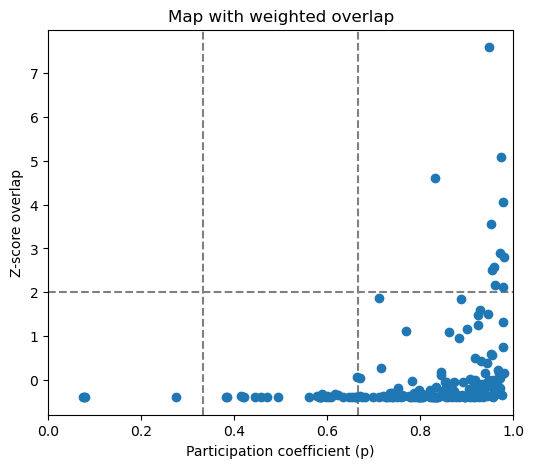

In [88]:
fig_phase,ax = plt.subplots(figsize = (6,5))
ax.axvline(x=1/3, color='grey', linestyle='--',zorder =1)
ax.axvline(x=2/3, color='grey', linestyle='--',zorder = 1)
ax.axhline(y=2, color='grey', linestyle='--',zorder = 1)
ax.scatter(deg_particip.pc_w_out, deg_particip.z_overl,zorder = 2,label= deg_particip.country)
ax.set_xlim (0,1)
ax.set_xlabel('Participation coefficient (p)')
ax.set_title ('Map with weighted overlap')

ax.set_ylabel('Z-score overlap')

# Multilayer- Hubs:
bool_multihub= (deg_particip.pc_w_out>=0.6) & (deg_particip.z_out_overl>=2)
a = deg_particip.loc[bool_multihub,:].sort_values(by='z_overl',ascending=False)
a

Text(0, 0.5, 'z-score out degree')

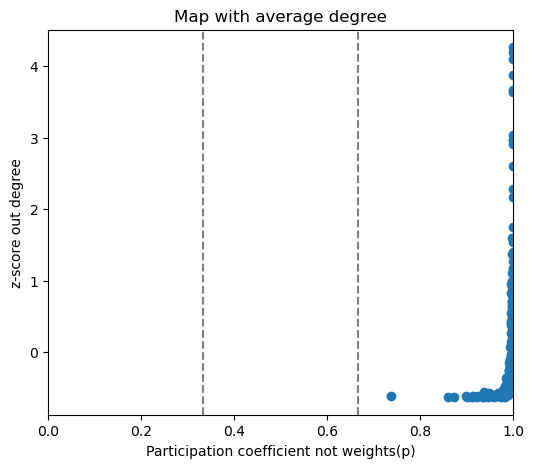

In [89]:
fig_phase,ax = plt.subplots(figsize = (6,5))
ax.axvline(x=1/3, color='grey', linestyle='--',zorder =1)
ax.axvline(x=2/3, color='grey', linestyle='--',zorder = 1)
ax.scatter(deg_particip.pc_out, deg_particip.z_out_deg,zorder = 2)
ax.set_xlim (0,1)
ax.set_xlabel('Participation coefficient not weights(p)')
ax.set_title ('Map with average degree')
ax.set_ylabel('z-score out degree')

# Old codes

In [ ]:
''' 
#Old Code

def Edge_overlap_w(data):
    """Calculate the weighted edge overlap for each 'origin_country_ISO' in a DataFrame.

    In weighted multilayer networks the edge overlap is the sum of all the weights of all out-links in each node.  

    Parameters:
    - data (pd.DataFrame): Input DataFrame containing at least the 'origin_country_ISO' and 'value' columns.

    Returns:
    pd.DataFrame: DataFrame with edge overlap calculated for each 'origin_country_ISO'.
    The output DataFrame has one column named 'overlap' representing the calculated edge overlap weights.

    Example:
    >>> df_result = Edge_overlap_w(input_data)
    """

    overlap_w= data.groupby(['origin_country_ISO']).apply(lambda group : group.value.sum())

    overlap_w= pd.DataFrame(overlap_w.sort_values(ascending=False),columns=['o_i'])
    return overlap_w

def Edge_overlap(data):
    """Calculate the (non-weighted) edge overlap for each 'origin_country_ISO' in a DataFrame.

    In weighted multilayer networks the edge overlap is the sum of all the weights of all out-links in each node.  

    Parameters:
    - data (pd.DataFrame): Input DataFrame containing at least the 'origin_country_ISO' and 'value' columns.

    Returns:
    pd.DataFrame: DataFrame with edge overlap calculated for each 'origin_country_ISO'.
    The output DataFrame has one column named 'overlap' representing the calculated edge overlap weights.

    Example:
    >>> df_result = Edge_overlap_w(input_data)
    """

    overlap= data.groupby(['origin_country_ISO']).apply(lambda group : len(group))

    overlap= pd.DataFrame(overlap.sort_values(ascending=False),columns=['o_i'])
    return overlap
'''

In [ ]:
'''
# Overlap? Check for individual products. 
year= '2019-2021'# 2018
unit = '1000 US$'
products = ['Palm oil','Apples','Cane sugar, non-centrifugal']
key_wanted = [tuple([product, unit]) for product in products]
print(key_wanted[0])
data_g = data.groupby(['Food_group','unit']) 
data_net=data_g.get_group(key_wanted[0]) #
data_net
str_layer=data_net.loc[:,['origin_country_ISO','value']].pivot_table(index='origin_country_ISO', aggfunc='sum').sort_values(by = 'value',ascending=False)


test_strength = data.groupby(['Food_group','unit']).apply(lambda group: group.loc[:,['origin_country_ISO','value']].pivot_table(index='origin_country_ISO', aggfunc='sum').sort_values(by = 'value',ascending=False))
test_strength_og = test_strength.reset_index(level=['Food_group','unit','origin_country_ISO'])

strength_all = test_strength_og.groupby(['origin_country_ISO']).apply(lambda group: group.loc[:,['origin_country_ISO','value']].pivot_table(index='origin_country_ISO', aggfunc='sum').sort_values(by = 'value',ascending=False))

merged_str = pd.merge(test_strength_og, str_overlap, left_on= 'origin_country_ISO',right_index=True, how='left')

# Layer per layer strength: 
merged_str['contribution'] = (merged_str['value']/merged_str['total_val'])**2

sum_particip = merged_str.groupby(['origin_country_ISO']).apply(lambda group: group.loc[:,'value'].pivot_table(index='origin_country_ISO', aggfunc='sum').sort_values(by = 'value',ascending=False))

sum_test= merged_str.groupby(['origin_country_ISO']).apply(lambda group: group.contribution.sum())
L= len(data.Food_group.unique())
partic_coeff = (L/(L-1))*(1- sum_test)


print(merged_str)

data_g = data.groupby(['item','unit']) 
data_net=data_g.get_group(key_wanted) #

edges_multi_all


overlap= pd.DataFrame(np.zeros([len(country_metadata.ISO), len(country_metadata.ISO)]),
             columns= country_metadata['ISO'], index= country_metadata.ISO)
'''